## General instructions

1) Create a docker container using the image `waikatodatamining/mmsegmentation:1.2.2_cuda11.3` from docker hub which has `mmsegmentation` correctly setup.
2)
   a. For setting it up on Google Colab use the python library `udocker` and follow instructions by Sonny for setup ([Google Colab example](https://colab.research.google.com/drive/1wu6KD2aJ2zqgP0G1Z2-A0_p-kspbtAeT?usp=sharing)).

   b. For setting up locally, create container, install jupyter within container and launch it using below commands.
```bash
# For local setup, adjust shared memory size (shm-size) based on your available memory. Docker by default only permits 64MB which is insufficient for this use case.
docker run --gpus all -p8009:8009 --shm-size="128g" --name mmseg -it -v $(pwd):/workspace -w /workspace waikatodatamining/mmsegmentation:1.2.2_cuda11.3 bash
# Now run the jupyter notebook as a background process
nohup jupyter lab --ip=0.0.0.0 --port=8009 --allow-root &
# To obtain jupyter notebook token, use the below command
jupyter lab list
```
3) Once the container is up and running, clone mmsegmentation and copy notebook inside it
```bash
# Clone mmsegmentation inside your workspace
git clone https://github.com/open-mmlab/mmsegmentation.git
cd mmsegmentation
# Copy this notebook inside mmsegmentation directory
cp ~/Downloads/notebook.ipynb .
```
4) Install `mmdet` as it is required by [Mask2Former](https://github.com/open-mmlab/mmsegmentation/issues/3361).
```bash
pip install "mmdet>=3.0.0rc4"
```

## Import libraries

In [1]:
import argparse
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import subprocess
import warnings

from mim import download
from mmengine.logging import MMLogger
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot, MMSegInferencer
from tools.analysis_tools.get_flops import inference, parse_args
from tqdm import tqdm

# Set warnings to ignore UserWarning otherwise mmseg displays many deprecation warnings
logger = MMLogger.get_instance(name='MMLogger')
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore', category=UserWarning)

## Load dataset

1) Download the data by registering on city scape website [here](https://www.cityscapes-dataset.com/downloads/). Store it on the path `mmsegmentation/data/cityscapes/gtFine` and `mmsegmentation/data/cityscapes/leftImg8bit`.
2) Install `cityscapesscripts` library for processing the data into suitable format for use with `mmseg`.

In [3]:
!pip install -q cityscapesscripts

In [6]:
!python tools/dataset_converters/cityscapes.py data/cityscapes --nproc 8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5000/5000, 622.8 task/s, elapsed: 8s, ETA:     0s


In [44]:
from mmseg.datasets import CityscapesDataset
from mmengine.registry import init_default_scope
init_default_scope('mmseg')

data_root = 'data/cityscapes'
data_prefix=dict(img_path='leftImg8bit/val', seg_map_path='gtFine/val')
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

dataset = CityscapesDataset(data_root=data_root, data_prefix=data_prefix, test_mode=True, pipeline=test_pipeline)

Total images in dataset: 500


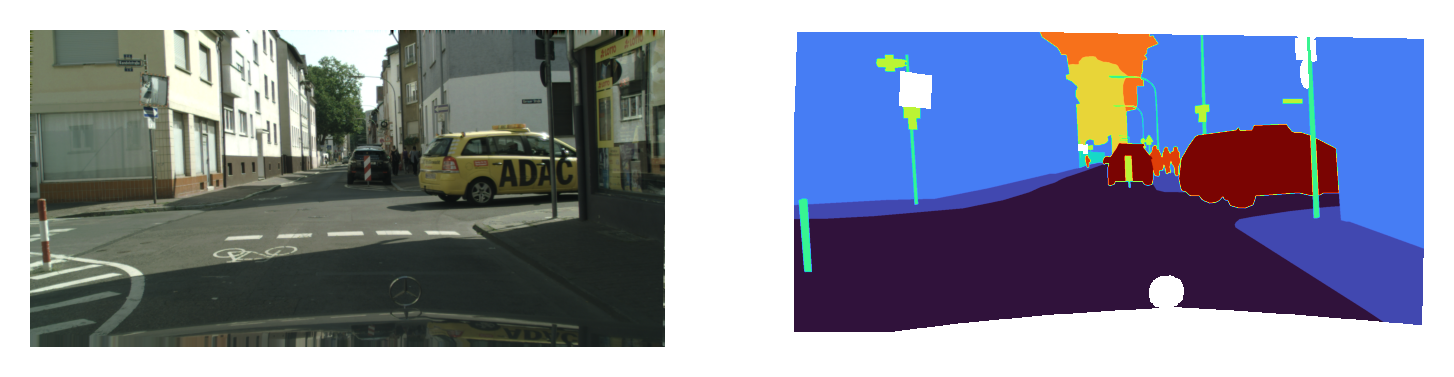

In [75]:
import numpy as np
import matplotlib.image as mpimg

print(f'Total images in dataset: {len(dataset)}')
index = 0
img = mpimg.imread(dataset[index]['data_samples'].img_path)
seg = mpimg.imread(dataset[index]['data_samples'].seg_map_path)
seg[seg==1] = np.nan # mask background segments, imread loads values between 0 to 1

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(seg, cmap='turbo')
axes[1].axis('off')

plt.show()

## View and download checkpoints

In [34]:
# models is a list of model name checkpoints
models = MMSegInferencer.list_models('mmseg')

In [2]:
checkpoints = [
    'pidnet-s_2xb6-120k_1024x1024-cityscapes',
    'pidnet-m_2xb6-120k_1024x1024-cityscapes',
    'pidnet-l_2xb6-120k_1024x1024-cityscapes',
    # 'pspnet_r18-d8_4xb2-80k_cityscapes-512x1024',
    # 'pspnet_r50-d8_4xb2-80k_cityscapes-512x1024',
    # 'pspnet_r101-d8_4xb2-80k_cityscapes-512x1024',
    'bisenetv2_fcn_4xb4-ohem-160k_cityscapes-1024x1024',
    'bisenetv2_fcn_4xb8-160k_cityscapes-1024x1024',
    'bisenetv2_fcn_4xb4-amp-160k_cityscapes-1024x1024',
    'segformer_mit-b0_8xb1-160k_cityscapes-1024x1024',
    'segformer_mit-b1_8xb1-160k_cityscapes-1024x1024',
    'segformer_mit-b2_8xb1-160k_cityscapes-1024x1024',
    'ddrnet_23-slim_in1k-pre_2xb6-120k_cityscapes-1024x1024',
    'ddrnet_23_in1k-pre_2xb6-120k_cityscapes-1024x1024',
    'mask2former_r101_8xb2-90k_cityscapes-512x1024',
    'mask2former_swin-b-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024',
    'mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024',
    'stdc1_4xb12-80k_cityscapes-512x1024',
    'stdc1_in1k-pre_4xb12-80k_cityscapes-512x1024',
    'stdc2_in1k-pre_4xb12-80k_cityscapes-512x1024'

    ## Below models were initially evaluated but left out as not efficient
    # # 'mobilenet-v2-d8_fcn_4xb2-80k_cityscapes-512x1024',
    # # 'mobilenet-v2-d8_pspnet_4xb2-80k_cityscapes-512x1024',
    # # 'mobilenet-v2-d8_deeplabv3_4xb2-80k_cityscapes-512x1024',
    # # 'mobilenet-v2-d8_deeplabv3plus_4xb2-80k_cityscapes-512x1024',
    # # 'setr_vit-l_naive_8xb1-80k_cityscapes-768x768',
    # # 'setr_vit-l_pup_8xb1-80k_cityscapes-768x768',
    # # 'setr_vit-l_mla_8xb1-80k_cityscapes-768x768',
    # # 'ocrnet_hr18s_4xb2-160k_cityscapes-512x1024',
    # # 'ocrnet_hr18_4xb2-160k_cityscapes-512x1024',
    # # 'ocrnet_hr48_4xb2-160k_cityscapes-512x1024',
]

In [3]:
checkpoints_dir = 'checkpoints'
pth_filenames = download('mmsegmentation', checkpoints, dest_root=checkpoints_dir)
pth_filenames = [
    os.path.join(checkpoints_dir, pth_filename)
    for pth_filename in pth_filenames
]
config_filenames = [
    os.path.join(checkpoints_dir, f'{ckpt}.py')
    for ckpt in checkpoints
]

# Save checkpoint and config in a JSON file
config_json = dict()
for conf, pth in zip(config_filenames, pth_filenames):
    config_json[conf] = pth
with open('config_list.json', 'w') as json_file:
    json.dump(config_json, json_file, indent=4)

processing pidnet-s_2xb6-120k_1024x1024-cityscapes...
pidnet-s_2xb6-120k_1024x1024-cityscapes_20230302_191700-bb8e3bcc.pth exists in /workspace/mmsegmentation/checkpoints
Successfully dumped pidnet-s_2xb6-120k_1024x1024-cityscapes.py to /workspace/mmsegmentation/checkpoints
processing pidnet-m_2xb6-120k_1024x1024-cityscapes...
pidnet-m_2xb6-120k_1024x1024-cityscapes_20230301_143452-f9bcdbf3.pth exists in /workspace/mmsegmentation/checkpoints
Successfully dumped pidnet-m_2xb6-120k_1024x1024-cityscapes.py to /workspace/mmsegmentation/checkpoints
processing pidnet-l_2xb6-120k_1024x1024-cityscapes...
pidnet-l_2xb6-120k_1024x1024-cityscapes_20230303_114514-0783ca6b.pth exists in /workspace/mmsegmentation/checkpoints
Successfully dumped pidnet-l_2xb6-120k_1024x1024-cityscapes.py to /workspace/mmsegmentation/checkpoints
processing bisenetv2_fcn_4xb4-ohem-160k_cityscapes-1024x1024...
bisenetv2_fcn_ohem_4x4_1024x1024_160k_cityscapes_20210902_112947-5f8103b4.pth exists in /workspace/mmsegmentati

## Evaluation
* Performance (IoU, Pixel accuracy)
* Time taken for each image
* FPS
* Computational power (in GFLOPS), number of params

In [7]:
def extract_model_name(path):
    # Use regex to find the model name
    match = re.search(r'([^/]+?)(?=_[0-9])', path)
    if match:
        return match.group(1)
    else:
        # Return the basename without extension if no match is found
        return os.path.splitext(os.path.basename(path))[0]

def estimate_flops(config_file, input_shape=[2048, 1024]):
    '''
    `mmseg` provides a command line tool in `tools/analysis_tools/get_flops.py` which we
    run using this method for modularity.

    Returns a dict containing `flops` and `params`.
    '''
    args = argparse.Namespace(
        config=config_file,
        shape=input_shape,
        cfg_options=None
    )    
    return inference(args, logger)

def estimate_fps(config_path, checkpoint_path):
    command = [
        'python', 'tools/analysis_tools/benchmark.py', config_path, checkpoint_path,
        '--log-interval', '50', '--work-dir', 'result/benchmark', '--repeat-times', '1'
    ]

    # Run the command using subprocess and capture the output
    result = subprocess.run(command, capture_output=True, text=True)
    out_logs = result.stdout
    fps_pattern = re.compile(r'Average fps of \d+ evaluations:\s*([\d.]+)')

    # Search for the pattern in the out_logs
    match = fps_pattern.search(out_logs)
    if match:
        fps = float(match.group(1))
        return fps
    else:
        return None

In [8]:
def extract_metrics(out_logs):
    # Define regex patterns
    class_pattern = re.compile(r'\|\s+(\w[\w\s]*)\s+\|\s+([\d.]+)\s+\|\s+([\d.]+)\s+\|')
    metric_pattern = re.compile(r'Iter\(test\) \[\d+/\d+\]\s+aAcc:\s*([\d.]+)\s*mIoU:\s*([\d.]+)\s*mAcc:\s*([\d.]+)\s*data_time:\s*([\d.]+)\s*time:\s*([\d.]+)')

    # Initialize dictionaries
    class_metrics = {}
    overall_metrics = {}

    # Extract class-based IoU values
    for match in class_pattern.finditer(out_logs):
        class_name, iou, acc = match.groups()
        class_metrics[class_name.strip()] = {'IoU': float(iou), 'Acc': float(acc)}

    # Extract metrics
    match = metric_pattern.search(out_logs)
    if match:
        aAcc, mIoU, mAcc, data_time, time = match.groups()
        overall_metrics = {
            'aAcc': float(aAcc),
            'mIoU': float(mIoU),
            'mAcc': float(mAcc),
            'data_time': float(data_time),
            'time': float(time)
        }

    return class_metrics, overall_metrics

def call_test_script(config_path, checkpoint_path):
    '''
    Returns class based metrics: IoU and pixel accuracy.
    Returns global metrics: mIoU, mean pixel accuracy, average pixel accuracy, time taken.
    Returns additional metrics: flops, params, fps
    '''
    # Derive the output directory from the config path filename
    config_filename = os.path.basename(config_path)
    output_dir = 'result/' + extract_model_name(config_path) + '_cityscapes'

    print('Estimating model accuracy')
    command = [
        'python', 'tools/test.py', config_path, checkpoint_path,
        '--out', output_dir
    ]

    # Run the command using subprocess and capture the output
    result = subprocess.run(command, capture_output=True, text=True)

    # Print the output in Jupyter cell
    # print(result.stdout)
    # print(result.stderr)

    # Store the output in a variable
    out_logs = result.stdout #+ result.stderr

    # Extract metrics from logs
    class_metrics, global_metrics = extract_metrics(out_logs)

    # Additional metrics
    print('Estimating model computational requirements')
    try:
        flops_data = estimate_flops(config_file)
        global_metrics['FLOPS'] = flops_data['flops']
        global_metrics['Params'] = flops_data['params']    
        global_metrics['FPS'] = estimate_fps(config_file, checkpoint_file)
    except Exception as e:
        pass # Additional metrics not supported for this model

    # Return the output logs
    return class_metrics, global_metrics

In [ ]:
class_dict = dict()
global_dict = dict()

for config_file, checkpoint_file in tqdm(config_json.items(), desc='Models evaluated'):
    class_metrics, global_metrics = call_test_script(config_file, checkpoint_file)

    model_name = extract_model_name(config_file)
    class_dict[model_name] = class_metrics
    global_dict[model_name] = global_metrics

Models evaluated:   0%|          | 0/17 [00:00<?, ?it/s]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:   6%|▌         | 1/17 [10:43<2:51:35, 643.47s/it]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:  12%|█▏        | 2/17 [31:39<4:10:55, 1003.71s/it]

Estimating model accuracy


In [12]:
# get data frame from class metrics dictionary
classes = set()
for model in class_dict.values():
    classes.update(model.keys())

# Create a DataFrame with multi-level columns
columns = pd.MultiIndex.from_product([class_dict.keys(), ['IoU', 'Acc']], names=['Model', 'Metric'])
class_df = pd.DataFrame(index=list(classes), columns=columns)

# Populate the DataFrame with class_dict
for model_name, metrics in class_dict.items():
    for class_name, values in metrics.items():
        class_df.loc[class_name, (model_name, 'IoU')] = values['IoU']
        class_df.loc[class_name, (model_name, 'Acc')] = values['Acc']

# Display the DataFrame
class_df = class_df.T
class_df.to_csv('result/class_metrics_cityscapes.csv')
class_df

road   pole    bus traffic sign  \
Model                                Metric                                     
pidnet-s                             IoU     98.31  65.14  88.03        79.06   
                                     Acc      99.1  77.51  91.78        87.24   
pidnet-m                             IoU     98.24  66.33   90.6        80.49   
                                     Acc     99.05  78.67  94.43        88.97   
pidnet-l                             IoU     98.34  67.26  92.42        82.11   
                                     Acc     99.11  79.49  95.62        89.43   
bisenetv2_fcn                        IoU     97.96  60.79  74.31        75.12   
                                     Acc     98.91  72.21  90.03         83.8   
segformer_mit-b0                     IoU     98.03   62.6  83.88        77.72   
                                     Acc     98.95  72.51  89.76        84.88   
segformer_mit-b1                     IoU      98.2  65.94  86.71        80.77   
                                     Acc     98.99   76.0  93.25         87.5   
segformer_mit-b2                     IoU     98.38  68.63  91.33        81.78   
                                     Acc     99.12  78.95  95.45        89.01   
ddrnet                               IoU     98.27  66.83  90.19        80.87   
                                     Acc     98.99  78.62  93.87        88.12   
mask2former_r101                     IoU     98.17  69.53   90.9        81.05   
                                     Acc     98.96  79.85  95.36        87.81   
mask2former_swin-b-in22k-384x384-pre IoU     98.53   72.2  92.08        85.01   
                                     Acc      99.1  82.45  96.24        90.89   
mask2former_swin-l-in22k-384x384-pre IoU     98.61  72.44  92.71        84.43   
                                     Acc     99.25  83.16  96.84        90.58   
stdc1                                IoU     97.63  55.04  81.19        72.31   
                                     Acc     98.62  66.53  86.56         81.1   
stdc1_in1k-pre                       IoU     97.97  58.19   85.8        76.74   
                                     Acc     98.98  70.51  90.46        85.21   
stdc2_in1k-pre                       IoU     98.26   61.0  86.62        77.93   
                                     Acc     99.09   72.4  92.09        86.57   

                                             fence   wall  rider building  \
Model                                Metric                                 
pidnet-s                             IoU     60.59  54.39  64.98    92.71   
                                     Acc      72.4  60.85  79.62    96.49   
pidnet-m                             IoU     64.71  57.93  67.53     93.1   
                                     Acc     73.95  64.65   80.4     96.8   
pidnet-l                             IoU     65.64  64.41   68.3     93.4   
                                     Acc     74.64  70.49  81.56    96.86   
bisenetv2_fcn                        IoU     56.71  50.53  54.46    91.54   
                                     Acc     66.81   57.8  66.73    96.22   
segformer_mit-b0                     IoU     56.82  58.76  57.39    92.23   
                                     Acc     66.19  65.28  69.63    96.73   
segformer_mit-b1                     IoU     57.97  62.56  60.46    92.82   
                                     Acc     65.01  69.22  72.11     96.9   
segformer_mit-b2                     IoU     62.61  66.17  65.61    93.36   
                                     Acc     70.24  72.39  78.56    96.93   
ddrnet                               IoU     64.25  55.25  66.98    93.07   
                                     Acc     76.01  60.86  81.07    96.81   
mask2former_r101                     IoU     64.55  58.36  67.15    93.15   
                                     Acc      75.0  65.37  77.51    97.08   
mask2former_swin-b-in22k-384x384-pre IoU     74.46   66.0  69.81    94.17  

In [13]:
global_df = pd.DataFrame(global_dict).T
global_df.to_csv('result/global_metrics_cityscapes.csv')
global_df

,aAcc,mIoU,mAcc,data_time,time,FLOPS,Params,FPS
pidnet-s,96.18,78.74,86.44,0.0341,0.9046,47.517G,7.721M,1.22
pidnet-m,96.35,80.22,87.25,0.0393,1.808,0.178T,28.763M,0.61
pidnet-l,96.49,80.89,88.07,0.0405,2.0555,0.276T,37.314M,0.53
bisenetv2_fcn,95.57,73.07,81.2,0.0391,1.3811,98.854G,3.359M,0.87
segformer_mit-b0,95.92,76.54,83.86,0.0398,5.3716,0.122T,3.72M,0.19
segformer_mit-b1,96.27,78.56,85.43,0.0355,6.4451,0.24T,13.683M,0.25
segformer_mit-b2,96.55,81.08,87.66,0.0233,5.7111,0.421T,24.728M,0.18
ddrnet,96.36,79.99,87.31,0.0212,0.6467,0.144T,20.299M,1.57
mask2former_r101,96.41,80.8,87.5,0.0189,5.7649,NaN,NaN,NaN
mask2former_swin-b-in22k-384x384-pre,96.93,83.52,90.14,0.0124,5.9814,NaN,NaN,NaN


<Figure size 4200x3000 with 0 Axes>

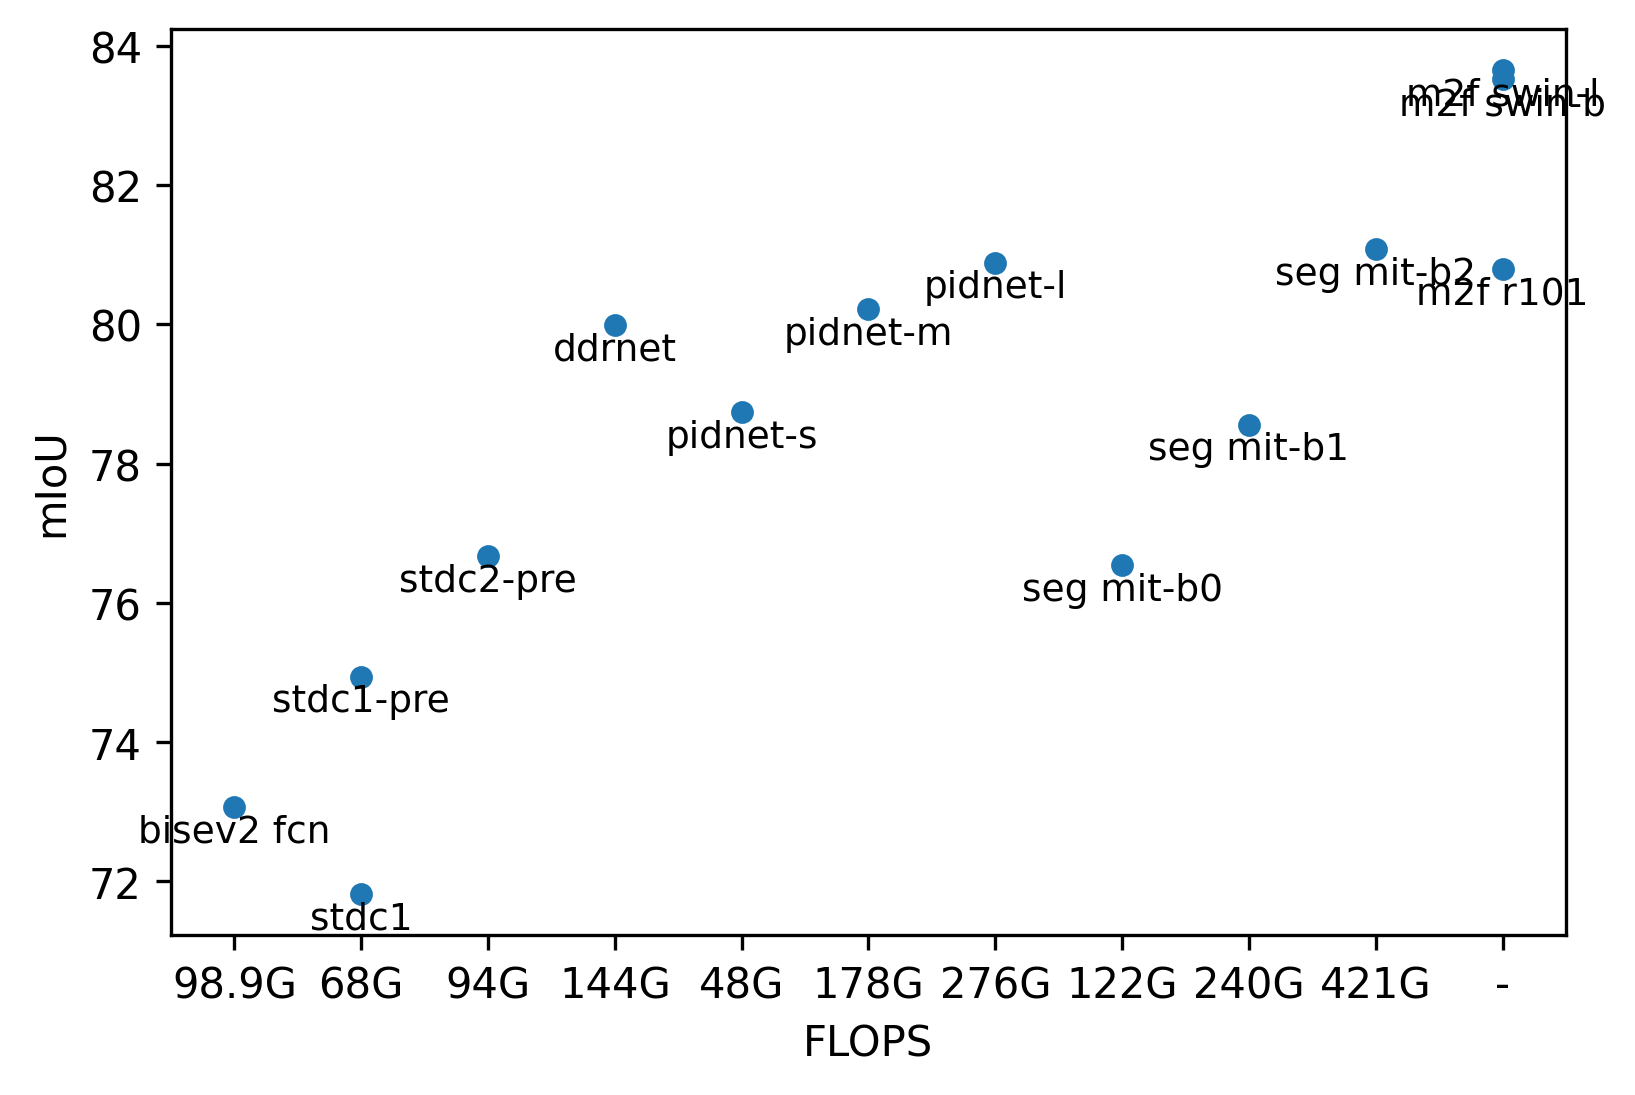

In [50]:
# Data from the provided table
data = {
    "Model": ["bisev2 fcn", "stdc1", "stdc1-pre", "stdc2-pre", "ddrnet", "pidnet-s", "pidnet-m", "pidnet-l", 
              "seg mit-b0", "seg mit-b1", "seg mit-b2", "m2f r101", "m2f swin-b", "m2f swin-l"],
    "mIoU": [73.07, 71.82, 74.94, 76.67, 79.99, 78.74, 80.22, 80.89, 76.54, 78.56, 81.08, 80.8, 83.52, 83.65],
    "mAcc": [81.2, 79.4, 82.13, 84.02, 87.31, 86.44, 87.25, 88.07, 83.86, 85.43, 87.66, 87.5, 90.14, 89.93],
    "FLOPS": ["98.9G", "68G", "68G", "94G", "144G", "48G", "178G", "276G", "122G", "240G", "421G", "-", "-", "-"],
    "Params": ["3.4M", "8.3M", "8.3M", "12.3M", "20.3M", "7.7M", "28.8M", "37.3M", "3.7M", "13.7M", 
               "24.7M", "63M", "107M", "216M"],
    "FPS": [47.3, 74.8, 74.8, 58.2, 108.1, 93.2, 39.8, 31.1, 15.2, 11.2, 7.4, "-", "-", "-"]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Scatter plot for FLOPS vs mIoU
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(14, 10))
df.plot(kind='scatter', x='FLOPS', y='mIoU', marker='o')

# Annotate each point with the model name
for i in range(df.shape[0]):
    plt.text(df['FLOPS'][i], df['mIoU'][i] - 0.5, df['Model'][i], fontsize=9, ha='center')

plt.xlabel('FLOPS')
plt.ylabel('mIoU')
plt.show()

In [52]:
!pip install textalloc

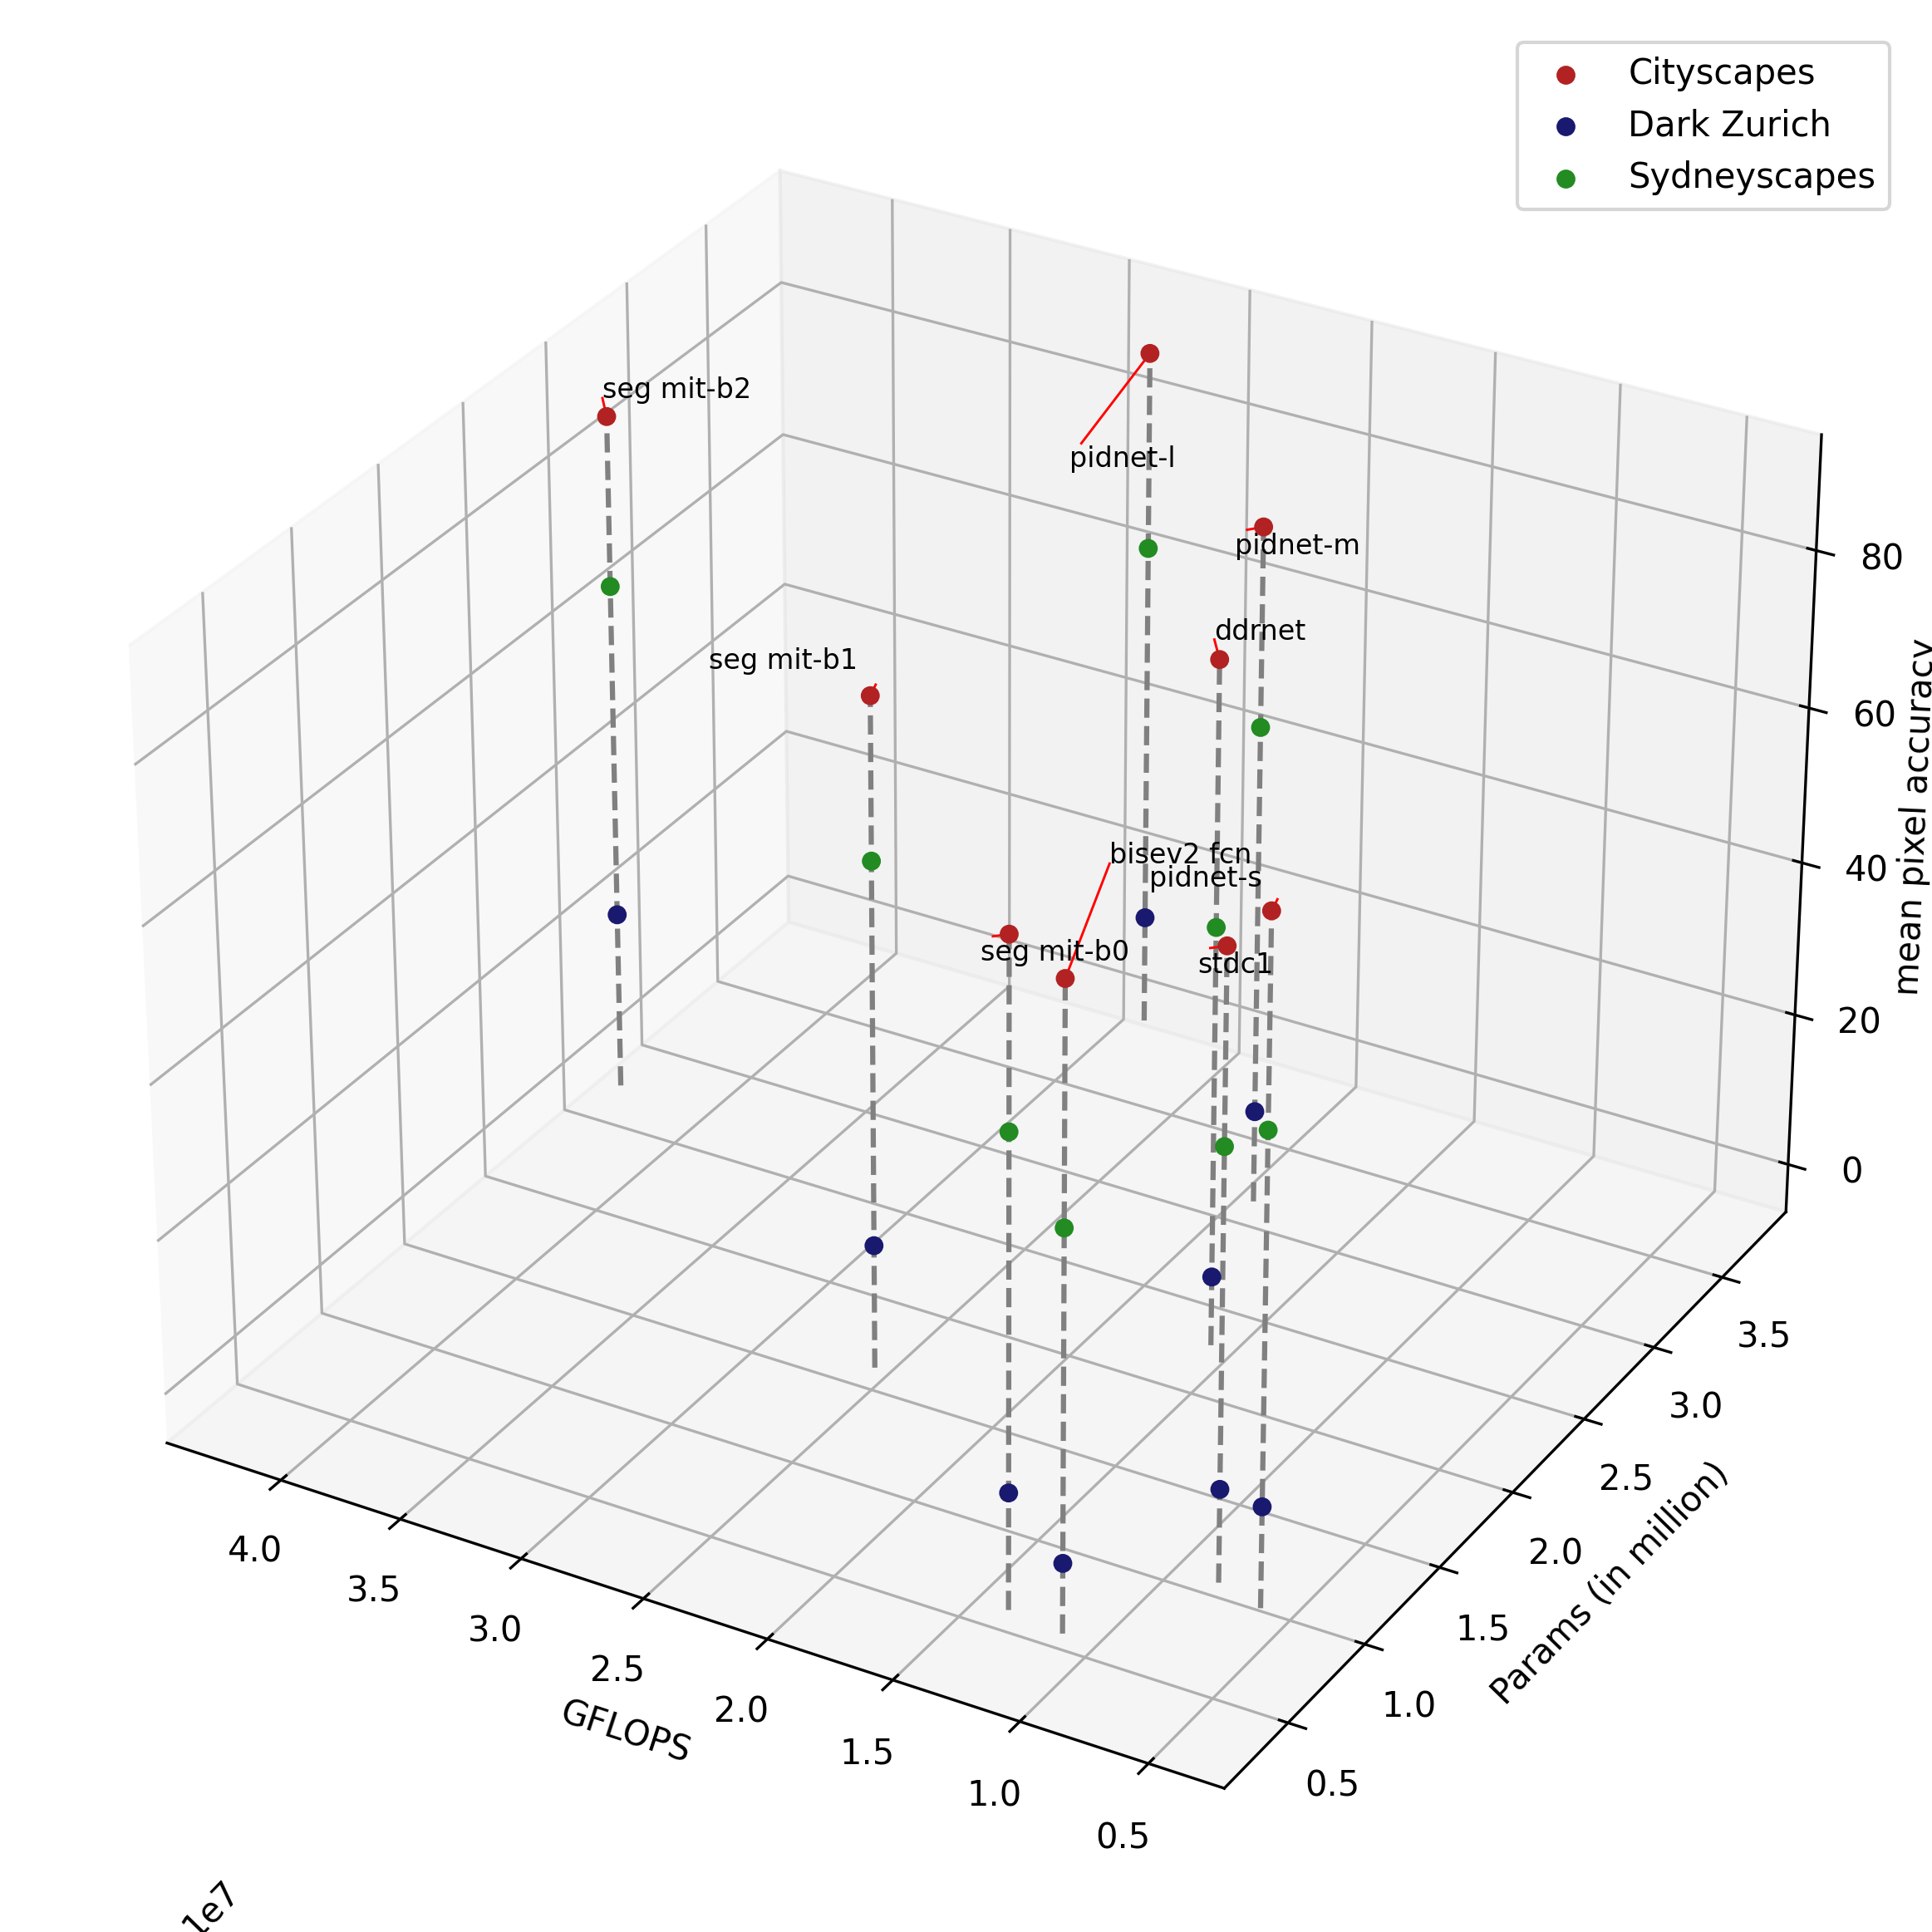

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data from the provided tables
data_cityscapes = {
    "Model": ["bisev2 fcn", "stdc1", "stdc1-pre", "stdc2-pre", "ddrnet", "pidnet-s", "pidnet-m", "pidnet-l", 
              "seg mit-b0", "seg mit-b1", "seg mit-b2"],
    "mIoU": [73.07, 71.82, 74.94, 76.67, 79.99, 78.74, 80.22, 80.89, 76.54, 78.56, 81.08],
    "mAcc": [81.2, 79.4, 82.13, 84.02, 87.31, 86.44, 87.25, 88.07, 83.86, 85.43, 87.66],
    "FLOPS": ["98.9G", "68G", "68G", "94G", "144G", "48G", "178G", "276G", "122G", "240G", "421G"],
    "Params": ["3.4M", "8.3M", "8.3M", "12.3M", "20.3M", "7.7M", "28.8M", "37.3M", "3.7M", "13.7M", 
               "24.7M"],
    "FPS": [47.3, 74.8, 74.8, 58.2, 108.1, 93.2, 39.8, 31.1, 15.2, 11.2, 7.4]
}

data_dark_zurich = {
    "Model": ["bisev2 fcn", "stdc1", "stdc1-pre", "stdc2-pre", "ddrnet",
              "pidnet-s", "pidnet-m", "pidnet-l",
              "seg mit-b0", "seg mit-b1", "seg mit-b2"],
    'mIoU': [46., 44.7, 34.3, 48.9, 33.6,
             40., 41.2, 46.8, 53.1, 53.8, 58.8],
    'mAcc': [9., 12., 10., 14., 9.,
             13., 12., 14., 15., 16., 23.]
}

data_sydney_scapes = {
    'Model': ["bisev2 fcn", "ddrnet", "stdc1", "stdc1-pre", "stdc2-pre",
              'pidnet-s', 'pidnet-m', 'pidnet-l', 'seg mit-b0', 'seg mit-b1',
              'seg mit-b2'],
    'mIoU': [37.67, 43.75, 37.32, 37.59, 44.1,
             45.96, 49.52, 47.62, 49.94, 52.66,
             54.64],
    'mAcc': [51., 55., 54., 52., 57.,
             60., 62., 63., 60., 65.,
             66.]
}

# Create DataFrames
df_cityscapes = pd.DataFrame(data_cityscapes)
df_dark_zurich = pd.DataFrame(data_dark_zurich)
df_sydney_scapes = pd.DataFrame(data_sydney_scapes)

# Ignore models as close proximity
models_to_ignore = ['stdc1-pre', 'stdc2-pre']
for model_name in models_to_ignore:
    df_cityscapes = df_cityscapes[df_cityscapes['Model'] != model_name].reset_index(drop=True)
    df_dark_zurich = df_dark_zurich[df_dark_zurich['Model'] != model_name].reset_index(drop=True)
    df_sydney_scapes = df_sydney_scapes[df_sydney_scapes['Model'] != model_name].reset_index(drop=True)

# Convert FLOPS and Params to numeric values for plotting
df_cityscapes['FLOPS'] = pd.to_numeric(df_cityscapes['FLOPS'].str.replace('G', 'e9').str.replace('T', 'e12'), errors='coerce')
df_cityscapes['Params'] = pd.to_numeric(df_cityscapes['Params'].str.replace('M', 'e6'), errors='coerce')

# Plotting in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot Cityscapes data
ax.scatter(df_cityscapes['FLOPS'], df_cityscapes['Params'], df_cityscapes['mAcc'], c='firebrick', label='Cityscapes', alpha=1)
# for i in range(df_cityscapes.shape[0]):
#     ax.text(df_cityscapes['FLOPS'][i], df_cityscapes['Params'][i], df_cityscapes['mAcc'][i], '', color='r')

# Plot Dark Zurich data
ax.scatter(df_cityscapes['FLOPS'], df_cityscapes['Params'], df_dark_zurich['mAcc'], c='midnightblue', label='Dark Zurich', alpha=1)
# for i in range(df_dark_zurich.shape[0]):
#     ax.text(df_cityscapes['FLOPS'][i], df_cityscapes['Params'][i], df_dark_zurich['mAcc'][i], '', color='g')

# Plot SydneyScapes data
ax.scatter(df_cityscapes['FLOPS'], df_cityscapes['Params'], df_sydney_scapes['mAcc'], c='forestgreen', label='Sydneyscapes', alpha=1)
# for i in range(df_sydney_scapes.shape[0]):
#     ax.text(df_cityscapes['FLOPS'][i], df_cityscapes['Params'][i], df_sydney_scapes['mAcc'][i], '', color='b')

# Plotting 3D lines and labels
x_lines = [[_x, _x] for _x in df_cityscapes['FLOPS']]
y_lines = [[_y, _y] for _y in df_cityscapes['Params']]
z_lines = [[0, _z] for _z in df_cityscapes['mAcc']]
text_list = df_cityscapes['Model'].tolist()
for xl,yl,zl in zip(x_lines, y_lines, z_lines):
    ax.plot(xl, yl, zl, "--", color='gray')
ta.allocate(ax, df_cityscapes['FLOPS'], df_cityscapes['Params'], text_list, z=df_cityscapes['mAcc'],
        x_scatter=df_cityscapes['FLOPS'], y_scatter=df_cityscapes['Params'], z_scatter=df_cityscapes['mIoU'],
        x_lines=x_lines, y_lines=y_lines, z_lines=z_lines,
        avoid_label_lines_overlap=False, #direction='south',
        draw_all=True, linewidth=0.7, textsize=8, max_distance=0.5)

ax.invert_xaxis()
# ax.invert_yaxis()
# Set y-axis to be exponential
# ax.set_yscale('log')

ax.set_xlabel('GFLOPS')
ax.set_ylabel('Params (in million)')
ax.set_zlabel("mean pixel accuracy", rotation=90, labelpad=-0.9)
plt.legend()
plt.savefig('result/accuracy.png')
plt.show()

## Command line equivalent
`no need to run`

In [14]:
# !python tools/test.py \
#     configs/segformer/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py \
#     checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth \
#     --out result/segformerb0_result

# !python tools/analysis_tools/benchmark.py \
#     configs/segformer/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py \
#     checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth \
#     --log-interval 50 \
#     --work-dir result/benchmark \
#     --repeat-times 1

Run 1:
/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth
Done image [50 / 200], fps: 22.51 img / s
Done image [100/ 200], fps: 22.52 img / s
Done image [150/ 200], fps: 22.53 img / s
Done image [200/ 200], fps: 22.53 img / s
Overall fps: 22.53 img / s

Average fps of 1 evaluations: 22.53
The variance of 1 evaluations: 0.0


In [11]:
# !rm -r result/segformerb0_result/.ipynb_checkpoints/

In [12]:
!python tools/analysis_tools/confusion_matrix.py \
    configs/segformer/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py \
    result/segformerb0_result \
    result/confusion_matrix --show

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 500/500, 20.0 task/s, elapsed: 25s, ETA:     0stools/analysis_tools/confusion_matrix.py:100: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix.astype(np.float32) / per_label_sums * 100
Figure(11400x9120)


## Exploring the dataset

In [24]:
import os
import shutil
from mmseg.evaluation.metrics import CityscapesMetric

run_dir = '../evaluation'
run_index = '1'
run_path = os.path.join(run_dir, run_index)

if os.path.exists(run_path):
    shutil.rmtree(run_path)
os.makedirs(run_path)

metric = CityscapesMetric(output_dir=run_path, ignore_index=255, format_only=False, keep_results=True, collect_device='cpu', prefix=None)

03/26 05:12:55 - mmengine - WARNING - The prefix is not set in metric class CityscapesMetric.


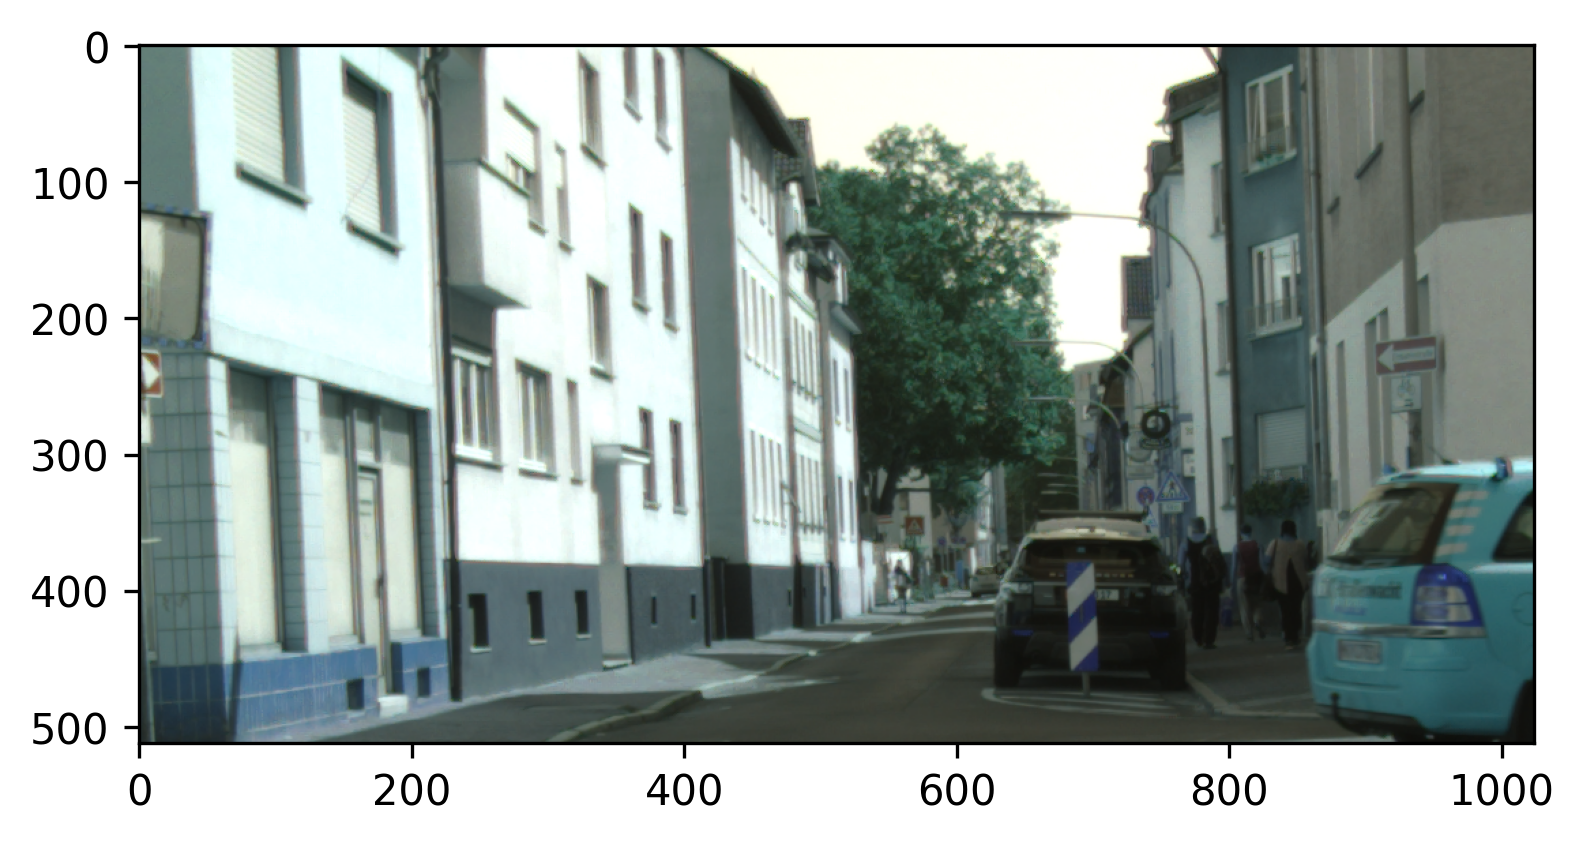

In [93]:
row = dataset[0]
img = np.array(row['inputs'])
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap='turbo')

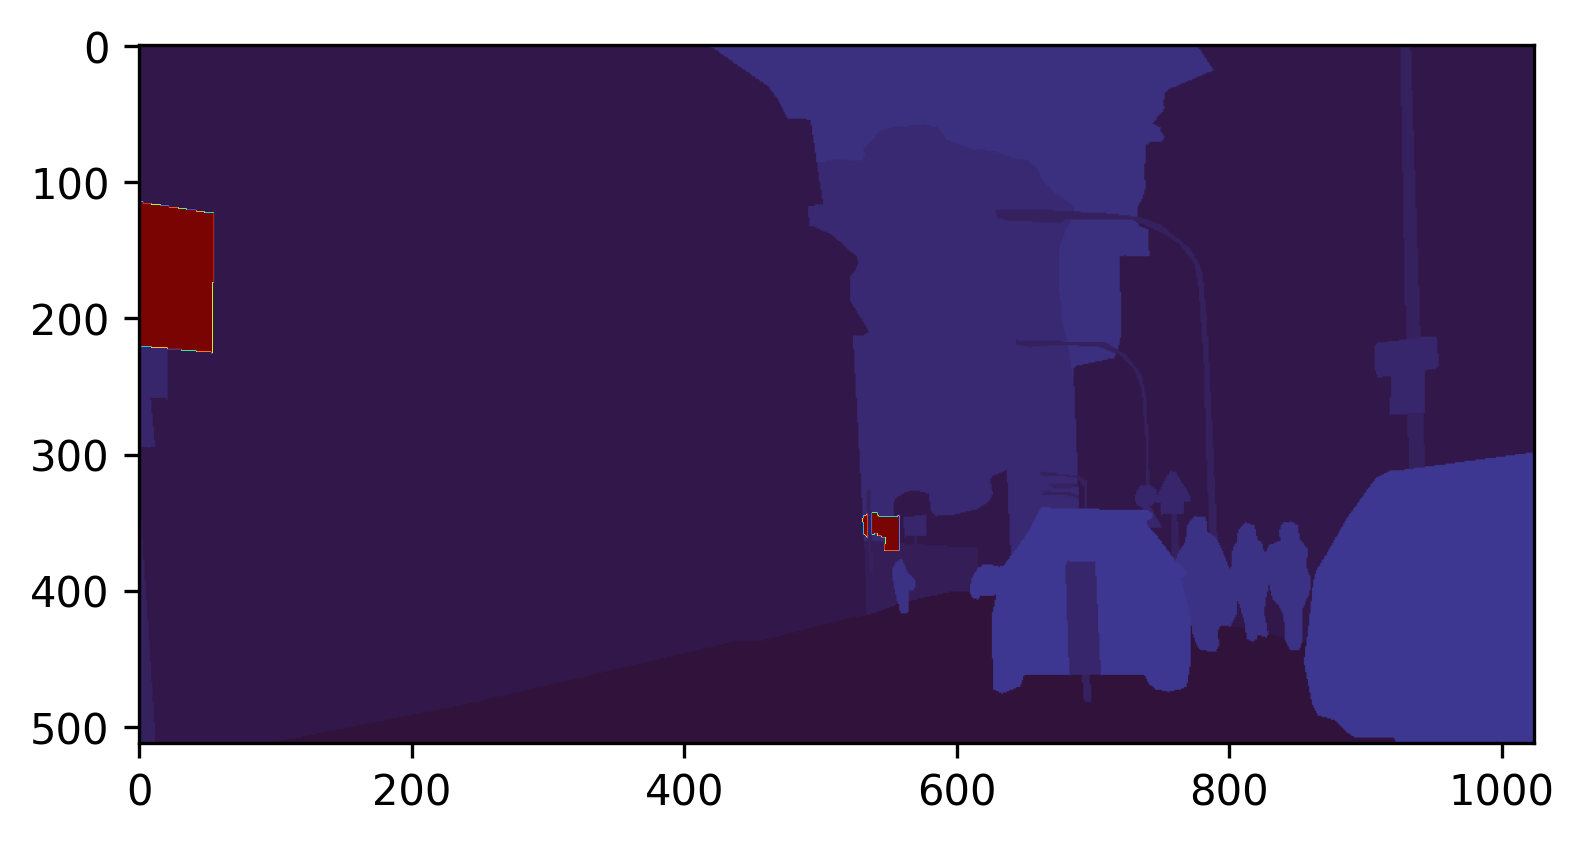

In [95]:
seg = np.array(row['data_samples'].gt_sem_seg.data.squeeze(0))
seg[seg==1] = 0 # mask background segments, imread loads values between 0 to 1
plt.imshow(seg, cmap='turbo')

In [26]:
for row in len(dataset):
    row = dataset[0]
    img = np.array(row['inputs'])
    img = mpimg.imread(row['data_samples'].img_path)
    seg = mpimg.imread(row['data_samples'].seg_map_path)
    seg[seg==1] = np.nan # mask background segments, imread loads values between 0 to 1
    

Help on method compute_metrics in module mmseg.evaluation.metrics.citys_metric:

compute_metrics(results: list) -> Dict[str, float] method of mmseg.evaluation.metrics.citys_metric.CityscapesMetric instance
    Compute the metrics from processed results.
    
    Args:
        results (list): Testing results of the dataset.
    
    Returns:
        dict[str: float]: Cityscapes evaluation results.

